# Chapter 12.2: N-body Simulation using Single Instruction, Multiple Threads (SIMT) and Tile-based Approach in Warp

![Example output](images/chapter-12.2/nbody_animation.gif)

## Overview

In the previous two notebooks, we introduced NVIDIA Warp as a framework for writing high-performance GPU code in Python and implemented a GPU-accelerated 2-D Ising model simulation. Through this parallel GPU implementation, we learned the importance of developing correct parallelization algorithms to faithfully reproduce the underlying physics of any physical system that we are modeling.

Following the theme of simulating physical systems to learn the basics of NVIDIA Warp for parallel computing, in this chapter we will implement an N-body simulation in NVIDIA Warp, first using the single instruction, multiple thread (SIMT) model and then using the tile-based model (both in Warp).

Through this implementation, you will learn the following:

* The simulation of another physical system using Warp, building on the previous notebook on the 2-D Ising model
* How to characterize code performance and use some code profiling tools available in Warp
* An introduction to the tile-based programming method in Warp

By the end of this chapter, you will have two variants of code for N-body simulation, one based on the SIMT paradigm and another based on the tile-based programming model. You will also have learned about tools available in Python and Warp to benchmark your code's time performance in greater detail.

It is strongly recommended to work through the [notebook on introduction to NVIDIA Warp](Chapter_12_Intro_to_NVIDIA_Warp.ipynb) and [GPU-Accelerated Ising Model Simulation in NVIDIA Warp](Chapter_12.1_IsingModel_In_Warp.ipynb) before proceeding with this tutorial.

---
## Setup

Before we begin this tutorial, let us ensure we have all the necessary packages installed.

First, we will install NVIDIA Warp if it is not already available:


In [1]:
# Install NVIDIA Warp
%pip install warp-lang

# Install Matplotlib for plotting/animation
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Now let us import the necessary libraries and initialize Warp to check if GPU support is available:


In [2]:
# Core imports
import numpy as np
import warp as wp

# Check for GPU availability
if wp.get_cuda_device_count() > 0:
    print("✓ GPU detected successfully")
else:
    print("No GPU detected!")

Warp 1.9.0 initialized:
   CUDA Toolkit 12.8, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA RTX 5000 Ada Generation Laptop GPU" (16 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/snidhan/.cache/warp/1.9.0
✓ GPU detected successfully


---
## Introduction: Exploring avenues for further speed up of an already GPU accelerated code

In the last notebook, we went through an example of how to correctly model a physical system (2-D Ising model) using Warp.

Now, we will go a step beyond the correctness of the model and explore how to profile our code and accelerate an already GPU-accelerated implementation.

Similar to the 2-D Ising model, we choose the N-body simulation for its simplicity while also having underlying physics that makes it amenable to a tile-based programming model.

Like the previous notebook, let us begin by understanding the physics behind the N-body simulation, then progressively build our GPU implementation, profile it, analyze potential avenues for further speedup, and finally explore the tile-based programming model.

---
## Background: The N-body simulation in physics and its numerical implementation 

### What is an N-body simulation?

An [N-body simulation](https://en.wikipedia.org/wiki/N-body_simulation) models the temporal evolution of a system of particles, typically under the influence of physical forces such as gravity. N-body simulations are widely used in astrophysics to study the dynamics of systems of planets, stars, and galaxies. Readers are strongly encouraged to go through section 31.1 of the [Fast N-Body Simulation with CUDA](https://developer.nvidia.com/gpugems/gpugems3/part-v-physics-simulation/chapter-31-fast-n-body-simulation-cuda) webpage for additional context on why we care about speeding up the N-body simulation.

### Numerical setup

The N-body simulation in this tutorial evolves a system of particles interacting with each other through gravity. Each particle exerts an attractive gravitational force on every other particle in the system. For a particle given by index $i$ and mass $m_i$, we approximate the net force on the particle $\mathbf{F}_i$ as:

$$
\mathbf{F}_i \approx G m_i \sum_{j=1}^{N} \frac{ m_j \mathbf{r}_{ij} }{ \left(\mathbf{r}_{ij} \cdot \mathbf{r}_{ij}  + \epsilon^2 \right)^{3/2} },
$$
where $\mathbf{r}_{ij} = \mathbf{x}_j - \mathbf{x}_i$, $\mathbf{x}_j$ and $\mathbf{x}_i$ are the position vectors of particles indexed $j$ and $i$, respectively. $\epsilon$ is a *softening factor* to prevent numerical instabilities when two particles are very close to each other. For convenience and without any loss of generality, we set $G=1$ and do not explicitly use it in the code.


### How to calculate the position of any particle in the system as a function of time?

1. For any particle $i$, we can calculate its acceleration at a given time $t_n$ as:
$$
\mathbf{a}_i^{n} = \frac{\mathbf{F}_i^{n}}{m_{i}} = G \sum_{j=1}^{N} \frac{ m_j \mathbf{r}_{ij} }{ \left(\mathbf{r}_{ij} \cdot \mathbf{r}_{ij}  + \epsilon^2 \right)^{3/2} }.
$$

In the formula above and subsequent formulae, superscript $n$ refers to the values of variables (forces, positions, accelerations, velocities) at time $t_n$.

2. We obtain the velocity of the given particle at time $t_{n+1}$ as:

$$
\mathbf{v}_i^{n+1} = \mathbf{v}_i^{n} + \mathbf{a}_i^{n}\Delta t.
$$

3. Thereafter, the position of the particle is updated at time $t_{n+1}$ as follows:

$$
\mathbf{x}_i^{n+1} = \mathbf{x}_i^{n} + \mathbf{v}_i^{n+1}\Delta t.
$$

Interested readers can also take a look at the appendix of [Swope et al. 1981](https://apps.dtic.mil/sti/tr/pdf/ADA103095.pdf) (page 53 onward).

**Exercise**: Starting with equations 1 to 3, show that the above-mentioned method can equivalently be expressed as
$$
\frac{d^2 \mathbf{x}_i}{d t^{2}} = \mathbf{a}_i \approx  \frac{\mathbf{x}_i^{n+1} -2 \mathbf{x}_{i}^n + \mathbf{x}_{i}^{n-1}}{\Delta t^{2}} = \mathbf{a}_i^{n}
$$

In the next sections, we will first implement a baseline simulation in Warp using a single instruction, multiple threads (SIMT) approach. We will then benchmark the SIMT code and delve into a tile-based paradigm for an even more performant code.

---
## A baseline SIMT implementation

The baseline implementation consists of mainly these N steps:

1. Initialize the N-body simulation parameters and arrays using `def initi_problem (num_bodies)` function

### Initializing the simulation using NumPy and Warp

The cell below implements the `def init_problem(num_bodies)` function to initialize positions and velocities of particles using NumPy. The following arrays are allocated on the GPU:

- **Position arrays**: We use two position arrays to avoid race conditions in the Warp kernel. These arrays are swapped at each time step.
  - Data type: Three-component float vector (`wp.vec3`)
  - Shape: `(N,)`
  - Initial values: Random positions uniformly distributed in space

- **Velocity array**: Stores the velocity of each particle.
  - Data type: Three-component float vector (`wp.vec3`)
  - Shape: `(N,)`
  - Initial values: Random velocities uniformly distributed in [-1, 1]

- **Mass array**: While not strictly necessary for this basic example, including masses makes it easier to extend the code to handle variable particle masses.
  - Data type: Float (`wp.float32`)
  - Shape: `(N,)`
  - Initial values: 1.0 (unit mass for all particles)

For convenience, we first initialize the arrays on the CPU using NumPy, then transfer them to Warp arrays on the GPU.

In [3]:
def init_problem(num_bodies):
    """Initialize N-body simulation parameters and arrays.

    Creates initial positions, velocities, and masses for a system of particles
    that will be used in the N-body gravitational simulation. Positions are
    uniformly distributed in a cube with size scaled by particle count to
    maintain constant density.

    Args:
        num_bodies (int): Number of particles in the simulation.

    Returns:
        tuple: A tuple containing:
            - pos_array_0 (wp.array): Initial position array on GPU (shape: [num_bodies, 3]).
            - pos_array_1 (wp.array): Empty position array for double buffering.
            - vel_array (wp.array): Initial velocity array on GPU (shape: [num_bodies, 3]).
            - mass_array (wp.array): Mass array on GPU (all particles have unit mass).
            - scale (float): Scale factor for the simulation domain.
            - init_pos_np (np.ndarray): Initial positions on CPU for visualization.

    Note:
        Uses a fixed random seed (42) for reproducible results.
    """
    # Initialize random number generator with fixed seed for reproducibility.
    rng = np.random.default_rng(42)

    # Calculate scale factor to maintain constant particle density as N increases.
    # The cube root scaling ensures constant density in 3D space.
    scale = 10.0 * (num_bodies / 1024) ** (1 / 3)

    # Generate initial conditions on CPU using NumPy.
    # Positions are uniformly distributed within a cube of size [-scale, scale]^3.
    init_pos_np = rng.uniform(low=-scale, high=scale, size=(num_bodies, 3))

    # Velocities are uniformly distributed in [-1, 1]^3 for initial random motion.
    init_vel_np = rng.uniform(low=-1.0, high=1.0, size=(num_bodies, 3))

    # All particles have unit mass for simplicity.
    mass_array_np = np.ones(num_bodies)

    # Transfer data from CPU (NumPy) to GPU (Warp).
    pos_array_0 = wp.array(init_pos_np, dtype=wp.vec3)

    # Create second position array for double buffering technique.
    # This avoids race conditions when updating positions in parallel.
    pos_array_1 = wp.empty_like(pos_array_0)

    # Transfer velocity and mass data to GPU.
    vel_array = wp.array(init_vel_np, dtype=wp.vec3)
    mass_array = wp.array(mass_array_np, dtype=wp.float32)

    return pos_array_0, pos_array_1, vel_array, mass_array, scale, init_pos_np

Let us now set the key simulation parameters for the problem at hand.

- `dt`: Timestep for the numerical setup
- `num_bodies`: Total number of bodies we are interested in simulating
- `SOFTENING_SQ`: Softening term to avoid blow-up in $\mathbf{F}_i$ if two particles are very close to each other

In [4]:
dt = 0.01
num_bodies = 1024
SOFTENING_SQ = 0.1**2

Let us know initialize the simulation and visualize the initial distribution of particles in the 3-D cartesian coordinate system.

In [5]:
import numpy as np
import warp as wp

# Call to initialize the position, velocity and mass arrays
pos_array_0, pos_array_1, vel_array, mass_array, scale, init_pos_np = init_problem(
    num_bodies
)

The cell above initializes the position, velocity, and mass arrays for particles for a given number of `num_bodies` particles.

Once the initial positions are set, let us visualize the system before moving to the implementation of the numerical scheme. Based on how initial position is set in `def init_problem(num_bodies)`, we should visually see an uniform distribution of particles in a cubical box of length 20 with centered at origin.

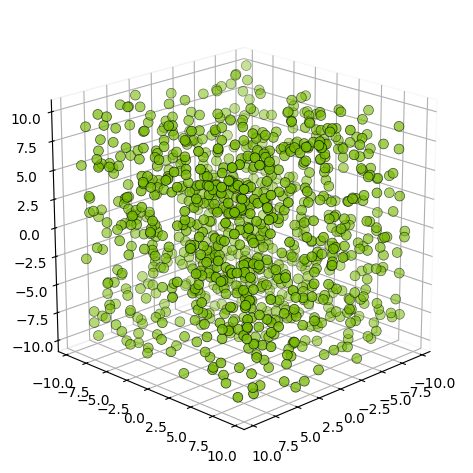

In [6]:
import matplotlib.pyplot as plt

# Create a figure with a dark background
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Create a scatter plot
scatter_plot = ax.scatter(
    init_pos_np[:, 0],
    init_pos_np[:, 1],
    init_pos_np[:, 2],
    c="#76b900",
    s=50,  # Set point size
    edgecolors="black",  # Black edges for contrast
    linewidth=0.5,  # Thin edge lines
    marker="o",  # Round markers
)

# Set axis limits with some padding
padding = scale * 0.1
ax.set_xlim(-scale - padding, scale + padding)
ax.set_ylim(-scale - padding, scale + padding)
ax.set_zlim(-scale - padding, scale + padding)

# Customize the grid
ax.grid(True, alpha=0.3, linestyle="--")

# Set a viewing angle
ax.view_init(elev=20, azim=45)

# Add pane colors for depth perception
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Customize tick labels
ax.tick_params(axis="both", which="major", labelsize=10)

# Add a subtle box around the plot region
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

plt.tight_layout()
plt.show()

#### Warp kernel for timestepping and updating the positions of the particles

Since we are working with the SIMT paradigm, it makes sense to launch a Warp kernel with a total number of threads equal to `num_bodies`. Each thread then takes care of updating the position of a single particle for a single timestep. We call this Warp kernel $N$ times, with each iteration from $0$ to $N$ corresponding to timesteps $t_1 = \Delta t$ to $t_{N} = N\Delta t$ (starting from $t_0=0$).

The Warp kernel we are about to implement needs to perform the following steps on each thread for a single particle, given the positions and velocities at time $t_n$:

- Calculate the acceleration of the particle $\mathbf{a}_i^{n}$ at time $t_n$ using the formula described in the Numerical setup section.
- Update the velocity of the particle: $\mathbf{v}_{i}^{n+1} = \mathbf{v}_{i}^{n} + \mathbf{a}_{i}^{n}\Delta t$.
- Calculate the updated position: $\mathbf{x}_{i}^{n+1} = \mathbf{x}_{i}^{n} + \mathbf{v}_{i}^{n+1}\Delta t$.

**Exercise**: Stop here and try to implement this Warp kernel and all the corresponding steps yourself. You can then compare your implementation with ours to see similarities and differences. Remember that the same algorithm can be implemented in different ways. In the final time-stepping loop, you can replace our kernel implementation with yours and observe whether the results change or remain similar.

The cell below implements two key components: (a) a Warp function named `def body_body_interaction(...)` that calculates the net gravitational acceleration of a particle, and (b) a Warp kernel named `def integrate_bodies(...)` that implements the time-stepping algorithm described above.

In [7]:
@wp.func
def body_body_interaction(
    num_bodies: int,
    masses: wp.array(dtype=float),
    body_position: wp.vec3,
    positions: wp.array(dtype=wp.vec3),
):
    """Calculate gravitational acceleration on a particle due to all other particles.

    Computes the net gravitational acceleration on a particle at the given position
    by summing the gravitational forces from all other particles in the system.
    Uses a softening factor to prevent numerical instabilities when particles are
    very close together.

    Args:
        num_bodies: Total number of particles in the system.
        masses: Array of particle masses indexed by particle ID.
        body_position: Position vector of the particle for which acceleration is computed.
        positions: Array of position vectors for all particles in the system.

    Returns:
        wp.vec3: Net acceleration vector acting on the particle.

    Note:
        The acceleration is computed using Newton's law of gravitation with G=1:
        a_i = Σ_j (m_j * r_ij / |r_ij + ε²|^(3/2))
        where r_ij is the vector from particle i to particle j, and ε is the
        softening factor.
    """

    # Initialize acceleration vector to zero.
    acc = wp.vec3(0.0, 0.0, 0.0)

    # Sum gravitational contributions from all other particles.
    for body_index in range(num_bodies):
        # Calculate displacement vector from current particle to other particle.
        r = positions[body_index] - body_position

        # Add softening factor to squared distance to avoid singularities.
        # This prevents blow-up when two particles get close to each other.
        dist_sq = wp.length_sq(r) + SOFTENING_SQ

        # Calculate inverse distance cubed for gravitational force formula.
        inv_dist = 1.0 / wp.sqrt(dist_sq)
        inv_dist_cubed = inv_dist * inv_dist * inv_dist

        # Accumulate acceleration contribution from this particle.
        # Force is proportional to mass and inverse square of distance.
        acc = acc + masses[body_index] * inv_dist_cubed * r

    return acc


@wp.kernel
def integrate_bodies(
    num_bodies: int,
    dt: float,
    masses: wp.array(dtype=float),
    old_position: wp.array(dtype=wp.vec3),
    velocity: wp.array(dtype=wp.vec3),
    new_position: wp.array(dtype=wp.vec3),
):
    """Integrate N-body system forward one timestep.

    Updates particle velocities and positions for one timestep using the
    gravitational forces between all particles. Each thread handles one particle,
    computing its acceleration, updating its velocity, and calculating its new
    position.

    Args:
        num_bodies: Total number of particles in the system.
        dt: Timestep size for integration.
        masses: Array of particle masses (shape: [num_bodies]).
        old_position: Current particle positions (shape: [num_bodies]).
        velocity: Current particle velocities, updated in-place (shape: [num_bodies]).
        new_position: Output array for updated positions (shape: [num_bodies]).

    Note:
        This kernel uses the SIMT paradigm where each thread processes one particle.
        The kernel should be launched with num_bodies threads.

        Integration scheme:
        1. a_i(t) = F_i(t) / m_i  (compute acceleration)
        2. v_i(t+dt) = v_i(t) + a_i(t) * dt  (update velocity)
        3. x_i(t+dt) = x_i(t) + v_i(t+dt) * dt  (update position)

        Double buffering is used for positions to avoid race conditions during
        parallel updates.
    """

    # Get thread ID - each thread handles one particle.
    i = wp.tid()

    # Calculate gravitational acceleration on this particle from all others.
    accel = body_body_interaction(num_bodies, masses, old_position[i], old_position)

    # Update velocity using forward Euler integration.
    # v(t+dt) = v(t) + a(t) * dt
    velocity[i] = velocity[i] + accel * dt

    # Update position using the newly computed velocity.
    # x(t+dt) = x(t) + v(t+dt) * dt
    # Note: We use new_position array to avoid race conditions.
    new_position[i] = old_position[i] + dt * velocity[i]

#### Warp kernel launch and timestepping

At this point, we have finished writing the only Warp kernel we need for this simulation.

The remaining task is to write a loop that repeatedly launches the Warp kernel and swaps the position arrays for the next iteration so that the updated positions become the current positions.

For the latter task, we can use this trick:

```python
(pos_array_0, pos_array_1) = (pos_array_1, pos_array_0)
```
If you worked through the 2-D Ising model in Warp notebook, you would remember that the above trick was used there as well but for updating the lattice site spins as the Monte Carlo simulation progressed.

The cell below performs the steps mentioned above. We re-initialize the inital state of the system using `def init_problem(...)`.

In [8]:
# Simulation parameters
dt = 0.01  # Time step for numerical integration
num_bodies = 1024  # Number of particles in the N-body system
SOFTENING_SQ = (
    0.1**2
)  # Softening parameter squared to prevent division by a very small number if two particles come closer
T = 100  # Total number of timesteps for which we run the simulation

# Initialize problem with particle positions, velocities, and masses
pos_array_0, pos_array_1, vel_array, mass_array, scale, init_pos_np = init_problem(
    num_bodies
)

# Main simulation loop that integrates particle motion over time
for _step_index in range(T):
    # Launch GPU kernel with one thread per particle
    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),  # Launch num_bodies threads
        inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
    )
    # Swap position buffers for next iteration (double buffering)
    pos_array_0, pos_array_1 = pos_array_1, pos_array_0

Module __main__ 090a5e8 load on device 'cuda:0' took 0.45 ms  (cached)


#### Animating the simulation

The cell below contains the boilerplate code for animating the N-body simulation we have built. Let's observe how the simulation evolves over time. Note that the Warp kernel call for each timestep is wrapped inside the `def update_plot(...)` function, which calls the `def integrate()` function. This function, in turn, launches the `integrate_bodies` kernel and swaps the arrays for each animation frame (representing a single timestep).

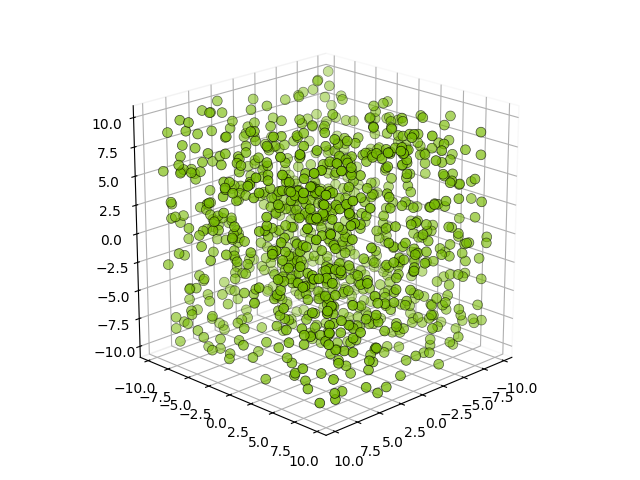

In [9]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Initialize problem with particle positions, velocities, and masses
pos_array_0, pos_array_1, vel_array, mass_array, scale, init_pos_np = init_problem(
    num_bodies
)


# Create an integrate function that launches the integrate_bodies kernel and swap arrays
def integrate():
    global pos_array_0, pos_array_1

    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),
        inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
    )

    # Swap arrays
    (pos_array_0, pos_array_1) = (pos_array_1, pos_array_0)


# Create figure and plot setup
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

scatter_plot = ax.scatter(
    init_pos_np[:, 0],
    init_pos_np[:, 1],
    init_pos_np[:, 2],
    c="#76b900",
    s=50,
    edgecolors="black",
    linewidth=0.5,
    marker="o",
)

# Set axis limits
padding = scale * 0.1
ax.set_xlim(-scale - padding, scale + padding)
ax.set_ylim(-scale - padding, scale + padding)
ax.set_zlim(-scale - padding, scale + padding)
ax.grid(True, alpha=0.3, linestyle="--")
ax.view_init(elev=20, azim=45)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.tick_params(axis="both", which="major", labelsize=10)
ax.set_box_aspect([1, 1, 1])


# Update function (like the working solution)
def update_plot(frame):
    integrate()  # Call the separate integrate function

    # Copy updated positions to CPU for visualization
    positions_cpu = pos_array_0.numpy()

    # Update scatter plot positions
    scatter_plot._offsets3d = (
        positions_cpu[:, 0],
        positions_cpu[:, 1],
        positions_cpu[:, 2],
    )

    return (scatter_plot,)


# Create animation (match working solution's parameters)
anim = FuncAnimation(
    fig,
    update_plot,
    frames=range(1000),  # Use range() like working solution
    interval=10,
    blit=True,
    repeat=False,
)

plt.tight_layout()
plt.show()

---
## Benchmarking the SIMT code

Now that we have established our baseline GPU implementation, let us define a performance metric and benchmark our SIMT implementation. We can choose our performance metric to be the **number of particle (pair-wise) interactions processed per second** ($\mathrm{PIPS}$). This can be defined as:

$$
\mathrm{PIPS} = \frac{N^{2} \times T}{\text{Time taken for T timesteps}},
$$

where $N$ and $T$ are the number of particles in the system and the number of timesteps, respectively.

In the cells below, we will explore three different ways of obtaining the $\textbf{time taken for T timesteps}$:

- Method 1 - Use the `time` module's `perf_counter()` or `perf_counter_ns()` functions
- Method 2 - Use CUDA events in Warp
- Method 3 - Use `wp.ScopedTimer()` as a context object. We can access the `.elapsed` attribute outside the context manager to get the elapsed time in **milliseconds**.

Let's go through each of these methods step by step and see what we get for our SIMT code.

##### Method 1 - Use the `time` module's `perf_counter()` or `perf_counter_ns()` functions

We will use the same code from our previous N-body simulation with minor modifications to add timing measurements using `time.perf_counter()`.

In [12]:
import time

# Simulation parameters
dt = 0.01  # Time step for numerical integration
num_bodies = 65536  # Number of particles in the N-body system
SOFTENING_SQ = (
    0.1**2
)  # Softening parameter squared to prevent division by a very small number if two particles come closer
T = 100

# Initialize problem with particle positions, velocities, and masses
pos_array_0, pos_array_1, vel_array, mass_array, scale, init_pos_np = init_problem(
    num_bodies
)

# Warmup loop for 5 timesteps
for _warmup_index in range(5):
    # Launch GPU kernel with one thread per particle
    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),  # Launch num_bodies threads
        inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
    )
    # Swap position buffers for next iteration (double buffering)
    pos_array_0, pos_array_1 = pos_array_1, pos_array_0


# Main simulation loop that integrates particle motion over time
start_time = time.perf_counter()  # Start the counter
for _step_index in range(T):
    # Launch GPU kernel with one thread per particle
    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),  # Launch num_bodies threads
        inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
    )
    # Swap position buffers for next iteration (double buffering)
    pos_array_0, pos_array_1 = pos_array_1, pos_array_0

time_taken = time.perf_counter() - start_time  # Record the time taken
print(f"Time taken for {T} timesteps: {time_taken} seconds")
print(f"PIPS: {num_bodies**2 * T / time_taken / 1e9} billion PIPS")

Time taken for 100 timesteps: 0.0012165779999122606 seconds
PIPS: 353036.738812452 billion PIPS


##### Method 2 - Use CUDA events in Warp

Events can be created with the `wp.Event(enable_timing=True)` argument to indicate that they will be used to calculate elapsed times.

Events must be recorded onto the stream of operations using `wp.record_event()`.

After both events have been recorded, we can use `wp.get_event_elapsed_time(start_event, end_event)` to return the elapsed time between the events in **milliseconds**.

In [ ]:
import time

# Simulation parameters
dt = 0.01  # Time step for numerical integration
num_bodies = 65536  # Number of particles in the N-body system
SOFTENING_SQ = (
    0.1**2
)  # Softening parameter squared to prevent division by a very small number if two particles come closer
T = 100


# Initialize problem with particle positions, velocities, and masses
pos_array_0, pos_array_1, vel_array, mass_array, scale, init_pos_np = init_problem(
    num_bodies
)

# Create events to record the start and end times of the simulation
start_event = wp.Event(enable_timing=True)
end_event = wp.Event(enable_timing=True)

# Warmup loop for 5 timesteps
for _warmup_index in range(5):
    # Launch GPU kernel with one thread per particle
    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),  # Launch num_bodies threads
        inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
    )
    # Swap position buffers for next iteration (double buffering)
    pos_array_0, pos_array_1 = pos_array_1, pos_array_0


wp.record_event(start_event)  # Record the start time

# Main simulation loop that integrates particle motion over time
for _step_index in range(T):
    # Launch GPU kernel with one thread per particle
    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),  # Launch num_bodies threads
        inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
    )
    # Swap position buffers for next iteration (double buffering)
    pos_array_0, pos_array_1 = pos_array_1, pos_array_0

wp.record_event(end_event)  # Record the end time

duration_seconds = (
    wp.get_event_elapsed_time(start_event, end_event) * 1e-3
)  # Calculate the elapsed time in seconds

print(f"Time taken for {T} timesteps: {duration_seconds} seconds")
print(f"PIPS: {num_bodies**2 * T / duration_seconds / 1e9} billion PIPS")

Time taken for 100 timesteps: 1.987925048828125 seconds
PIPS: 216.05277817349645 billion PIPS


##### Method 3: Use `wp.ScopedTimer()` as a context object

⚠️Caution⚠️: The `ScopedTimer` does not synchronize the host (CPU) with the device (GPU) by default. We must pass in `synchronize=True` for the `ScopedTimer` to synchronize before and after the timed section of the code.

In [14]:
import time

# Simulation parameters
dt = 0.01  # Time step for numerical integration
num_bodies = 65536  # Number of particles in the N-body system
SOFTENING_SQ = (
    0.1**2
)  # Softening parameter squared to prevent division by a very small number if two particles come closer
T = 100


# Initialize problem with particle positions, velocities, and masses
pos_array_0, pos_array_1, vel_array, mass_array, scale, init_pos_np = init_problem(
    num_bodies
)

# Warmup loop for 5 timesteps
for _warmup_index in range(5):
    # Launch GPU kernel with one thread per particle
    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),  # Launch num_bodies threads
        inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
    )
    # Swap position buffers for next iteration (double buffering)
    pos_array_0, pos_array_1 = pos_array_1, pos_array_0

with wp.ScopedTimer("Integration", synchronize=True) as timer:  # Create a scoped timer with label "Integration"
    # Main simulation loop that integrates particle motion over time
    for _step_index in range(T):
        # Launch GPU kernel with one thread per particle
        wp.launch(
            integrate_bodies,
            dim=(num_bodies,),  # Launch num_bodies threads
            inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
        )
        # Swap position buffers for next iteration (double buffering)
        pos_array_0, pos_array_1 = pos_array_1, pos_array_0


duration_seconds = timer.elapsed * 1e-3

print(f"Time taken for {T} timesteps: {duration_seconds} seconds")
print(f"PIPS: {num_bodies**2 * T / duration_seconds / 1e9} billion PIPS")

Integration took 1994.81 ms
Time taken for 100 timesteps: 1.994806275 seconds
PIPS: 215.30748874348714 billion PIPS


If you compare the PIPS values from methods 1, 2, and 3, you will notice that method 1 produces an unusually large result. This occurs because CUDA kernel launches are asynchronous with respect to the host CPU thread. When a kernel is launched using `wp.launch()`, the function schedules the kernel for execution on the GPU device but returns immediately to the CPU without waiting for the kernel to complete execution.

Consequently, when using `time.perf_counter()` to measure execution time, the recorded duration is incorrectly measured, even though the actual kernel execution takes much longer. This leads to an artificially inflated PIPS calculation.

In contrast, methods 2 and 3 use `wp.Event` and `wp.ScopedTimer` respectively, which properly synchronize with the GPU device and accurately measure the actual execution time of the kernel operations on the device.

Interested readers can read more about concurrency, streams, and synchronization in Warp [here](https://nvidia.github.io/warp/modules/concurrency.html).

---
## Tile-based programming approach

### How can we make our SIMT method even faster?

If you analyze the `body_body_interaction(...)` function in our SIMT code above, you will notice that it iterates over all particles to calculate the resulting acceleration for any given particle. Each time the contribution from a particle is calculated, the code must load both the positions (`positions[body_index]`) and masses (`masses[body_index]`) from global memory. 

One way to reduce this memory access overhead is to load a predefined chunk of masses and positions into shared memory within a thread block, making this data accessible to all threads in the block. With a chunk of particle data now in the faster shared memory, we can calculate acceleration contributions for this chunk much more efficiently than our previous approach, which required loading each individual particle's mass and position from the slower global memory for every computation.

Starting from Warp 1.5.0, developers have access to tile-based programming in NVIDIA Warp, which achieves this goal of cooperative operations across threads in a block.

### A quick introduction to tile-based programming in Warp

Before getting into details of how we can accelerate our N-body simulation using tile-based programming, we will quickly cover a few basics of tile-based programming in Warp using an example of row-wise summation of a matrix. Please also refer to this **https://nvidia.github.io/warp/modules/tiles.html** for a more comprehensive introduction to tile-based programming in Warp.  

Our input matrix is of size $(12, 256)$ with each row $i$ containing an identical entry of value $i$ across all columns. The code snippet below initializes our matrix.

In [15]:
import numpy as np
import warp as wp

N = 256  # Number of columns in our matrix
column_vector = np.arange(12, dtype=np.float32).reshape(
    -1, 1
)  # Create a column vector of size 12 [0, 1, 2, ..., 11]
a_np = np.tile(
    column_vector, (1, N)
)  # Tile the column vector 256 times to create a matrix of size (12, 256)
a_wp = wp.array(a_np)  # Convert our numpy array to a Warp array

print(f"{a_np.shape=}")
print(a_np)

a_np.shape=(12, 256)
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 2.  2.  2. ...  2.  2.  2.]
 ...
 [ 9.  9.  9. ...  9.  9.  9.]
 [10. 10. 10. ... 10. 10. 10.]
 [11. 11. 11. ... 11. 11. 11.]]


The output of our row-wise summation should be $[0, 256, 512, \cdots, 2816]$. Can you confirm this yourself before moving ahead?

Before implementing the tile-based method to do the row-wise summation of our matrix above, can you try to write the SIMT code for the same?

In [16]:
@wp.kernel
def compute(a: wp.array2d(dtype=float), b: wp.array(dtype=float)):
    """
    This kernel computes the row-wise sum of the input matrix a and stores the result in the output array b
    """
    i = wp.tid()  # Obtain the row index

    # Sum across the elements of the row
    sum = wp.float32(0.0)
    for j in range(a.shape[1]):
        sum += a[
            i, j
        ]  # Each thread i loads the matrix entry a[i,j] from the global memory

    # Store the result in b[i]
    b[i] = sum


b_wp = wp.empty(
    a_wp.shape[0], dtype=float
)  # Creaty an empty Warp array of size 12 to store our result

wp.launch(
    compute, dim=(a_wp.shape[0],), inputs=[a_wp], outputs=[b_wp]
)  # Launch the kernel with total of 12 threads, one for each row in our matrix

print(b_wp)

Module __main__ ed77e33 load on device 'cuda:0' took 0.43 ms  (cached)
[   0.  256.  512.  768. 1024. 1280. 1536. 1792. 2048. 2304. 2560. 2816.]


With tiles, we can use **all threads in a block** to cooperatively load an entire row of data into a tile object and call `wp.tile_sum()` on the tile.

Note that in the `compute_tiled` kernel below, we primarily call functions beginning with `wp.tile_`.

`wp.launch_tiled()` is also used instead of `wp.launch()`, but all `wp.launch_tiled()` does is to add a trailing dimension of `BLOCK_DIM` to the launch grid. Hence, the following are equivalent:

- `wp.launch_tiled(compute, dim=(a_wp.shape[0],), inputs=[a_wp], outputs=[b_wp], block_dim=BLOCK_DIM)`
- `wp.launch(compute, dim=(a_wp.shape[0], BLOCK_DIM), inputs=[a_wp], outputs=[b_wp], block_dim=BLOCK_DIM)`

In [17]:
# Both TILE_SIZE and BLOCK_DIM needs to be run-time constants
TILE_SIZE = 256  # Size of a single tile of data to laaded into either the private registers of each thread in the block or the shared memory of the block
BLOCK_DIM = 256  # Number of threads in a block

@wp.kernel
def compute_tiled(a: wp.array2d(dtype=float), b: wp.array2d(dtype=float)):
    i = wp.tid()  # Obtain the row index

    # Load a entire row aka tile from global memory using all threads in the block
    t = wp.tile_load(
        a[i],
        TILE_SIZE,
    )

    # Cooperatively compute the sum of the tile elements; s is a single-element tile
    s = wp.tile_sum(t)

    # store s in global memory
    wp.tile_store(b[i], s)


# Same as before, but now we create an empty Warp array of shape (12,1) since wp.tile_sum returns a single element tile
b_wp = wp.empty((a_wp.shape[0], 1), dtype=float)

# Kernel launch using wp.launch_tiled() with each block being of size BLOCK_DIM
wp.launch_tiled(
    compute_tiled,
    dim=(a_wp.shape[0],),
    inputs=[a_wp],
    outputs=[b_wp],
    block_dim=BLOCK_DIM,
)

print(
    b_wp
)  # Should be equivalent to our SIMT result, except b_wp being of size (12,1) instead of (12,)

Module __main__ a9ce1dd load on device 'cuda:0' took 0.58 ms  (cached)
[[   0.]
 [ 256.]
 [ 512.]
 [ 768.]
 [1024.]
 [1280.]
 [1536.]
 [1792.]
 [2048.]
 [2304.]
 [2560.]
 [2816.]]



In the `compute_tiled` kernel above, when the code calls `t = wp.tile_load(a[i], TILE_SIZE)`, it triggers a **coordinated memory operation** performed by all threads within the current CUDA thread block (which contains `BLOCK_DIM` threads).
 
The objective is to load `TILE_SIZE` elements from array `a`, starting at global memory index `i`, directly into the **private registers** of these threads.
 
Each thread in the block is responsible for loading a specific portion of the `TILE_SIZE` elements.
 
- When `TILE_SIZE=256` and `BLOCK_DIM=256`, each thread loads exactly one element from `a` into its register.
- When `TILE_SIZE=256` and `BLOCK_DIM=64`, each thread loads four elements from `a` into its register.
- When `TILE_SIZE=256` and `BLOCK_DIM=512`, only the first 256 threads load one element each from `a` into their registers, while the remaining 256 threads remain idle.
 
Since `TILE_SIZE` elements must ultimately be loaded, the work distribution depends on `BLOCK_DIM`. If `TILE_SIZE >= BLOCK_DIM`, each thread loads `TILE_SIZE/BLOCK_DIM` elements. Otherwise, only the first `TILE_SIZE` threads load one element each, while the remaining threads load nothing.

### Applying tile-based programming to N-body simulation

For our N-body simulation, recall that there is a Warp kernel `def integrate_bodies(...)` that calls the function `def body_body_interaction(...)`. Specifically, in the function `def body_body_interaction(...)`, we would like to load `TILE_SIZE` particle positions from global memory to the shared memory of a single CUDA block. The data for these particle positions in shared memory is accessible by all threads in the block.

The loop over body interactions is now done in **phases**: After each thread computes the interactions of the particle being updated with the `TILE_SIZE` particle positions that have been loaded into shared memory, another set of `TILE_SIZE` positions is read from global memory and loaded into shared memory.

We have created a new version of our `def body_body_interaction(...)` function, now called `def body_body_interaction_tile_based(...)` as shown below. We copy the `def integrate_bodies(...)` content to a new kernel `def integrate_bodies_tile_based(...)` where the only change is the call to the function `def body_body_interaction_tile_based(...)` instead of `def body_body_interaction(...)`.

In [18]:
TILE_SIZE = 256  # Tile size selected to be the same as the default block size
BLOCK_DIM = 256 # Size of a CUDA block

@wp.func
def body_body_interaction_tile_based(
    num_bodies: int,
    masses: wp.array(dtype=float),
    body_position: wp.vec3,
    positions: wp.array(dtype=wp.vec3),
):
    """Return the acceleration of the particle at position `body_position`."""
    acc = wp.vec3(0.0, 0.0, 0.0)

    for k in range(num_bodies / TILE_SIZE):
        pos_tile = wp.tile_load(positions, shape=TILE_SIZE, offset=k * TILE_SIZE)
        mass_tile = wp.tile_load(masses, shape=TILE_SIZE, offset=k * TILE_SIZE)

        for body_index in range(TILE_SIZE):
            r = pos_tile[body_index] - body_position

            dist_sq = wp.length_sq(r) + SOFTENING_SQ

            inv_dist = 1.0 / wp.sqrt(dist_sq)
            inv_dist_cubed = inv_dist * inv_dist * inv_dist

            acc = acc + mass_tile[body_index] * inv_dist_cubed * r

    return acc


@wp.kernel
def integrate_bodies_tile_based(
    num_bodies: int,
    dt: float,
    masses: wp.array(dtype=float),
    old_position: wp.array(dtype=wp.vec3),
    velocity: wp.array(dtype=wp.vec3),
    new_position: wp.array(dtype=wp.vec3),
):
    """This code stays the same as original def integrate_bodies_tile_based(...)
    except for the call to body_body_interaction_tile_based(...)
    """
    i = wp.tid()

    # Calculate gravitational acceleration on this particle from all others.
    # Notice now the call to tile-based body-body interaction code
    accel = body_body_interaction_tile_based(
        num_bodies, masses, old_position[i], old_position
    )

    # Update velocity using forward Euler integration.
    # v(t+dt) = v(t) + a(t) * dt
    velocity[i] = velocity[i] + accel * dt

    # Update position using the newly computed velocity.
    # x(t+dt) = x(t) + v(t+dt) * dt
    # Note: We use new_position array to avoid race conditions.
    new_position[i] = old_position[i] + dt * velocity[i]

### Validating the tile-based N-body simulation results against the SIMT implementation


Before analyzing the speed-up from the tile-based programming approach for our N-body simulation, let us first validate the approach. In the cell below, we run both the SIMT code and the tile-based code for 100 timesteps, append the output from the Warp kernels in both cases to numpy arrays, and then calculate the L2 norm of the difference between the two results averaged over 100 timesteps.

**Prequisite** -- Please make sure that you have run the cell that defines both `body_body_interaction` and `integrate_bodies` in the **A baseline SIMT implementation** section.

In [19]:
# Simulation parameters
dt = 0.01  # Time step for numerical integration
num_bodies = 65536  # Number of particles in the N-body system
SOFTENING_SQ = (
    0.1**2
)  # Softening parameter squared to prevent division by a very small number if two particles come closer
T = 100  # Number of timesteps to simulate


# Initialize problem with particle positions, velocities, and masses for tile-based approach
(
    pos_array_0,
    pos_array_1,
    vel_array,
    mass_array,
    scale,
    init_pos_np,
) = init_problem(num_bodies)

# Initialize separate arrays for SIMT approach comparison
# Note that since seed is set in init_problem, we will get same initial configurations of the particles 

(   pos_array_0_SIMT,
    pos_array_1_SIMT,
    vel_array_SIMT,
    mass_array_SIMT,
    scale_SIMT,
    init_pos_np_SIMT,
) = init_problem(num_bodies)


# Run SIMT-based approach and store positions over time
pos_array_over_time = []
for _step_index in range(T):
    # Launch SIMT-based kernel
    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),
        inputs=[
            num_bodies,
            dt,
            mass_array,
            pos_array_0,
            vel_array,
            pos_array_1,
        ],
    )
    # Double buffering: swap position arrays
    pos_array_0, pos_array_1 = pos_array_1, pos_array_0
    pos_array_over_time.append(pos_array_0.numpy())


# Run tile-based approach and store positions over time for comparison
pos_array_over_time_SIMT = []
for _step_index in range(T):
    # Launch tile-based kernel
    wp.launch(
        integrate_bodies_tile_based,
        dim=(num_bodies,),  # Launch num_bodies threads
        inputs=[
            num_bodies,
            dt,
            mass_array_SIMT,
            pos_array_0_SIMT,
            vel_array_SIMT,
            pos_array_1_SIMT,
        ],
        block_dim = BLOCK_DIM,  # Use specified block dimension for tiling
    )
    # Swap position buffers for next iteration (double buffering)
    pos_array_0_SIMT, pos_array_1_SIMT = pos_array_1_SIMT, pos_array_0_SIMT
    pos_array_over_time_SIMT.append(pos_array_0_SIMT.numpy())

Module __main__ abcceda load on device 'cuda:0' took 0.63 ms  (cached)


In [20]:
# Convert position arrays to numpy arrays for comparison
pos_array_over_time = np.asarray(pos_array_over_time)
pos_array_over_time_SIMT = np.asarray(pos_array_over_time_SIMT)

# Calculate L2 error between SIMT and tile-based approaches
# Compute norm across spatial dimensions (axis=2) then average over all particles and timesteps
l2_error = np.mean(
    np.linalg.norm((pos_array_over_time - pos_array_over_time_SIMT), axis=(2))
)
print(l2_error)

0.0


The `l2_error` between the SIMT code and tile-based code should come out to be zero, confirming that our tile-based approach for N-body simulation accurately reproduces the physics.

### Benchmarking the performance gain from tile-based approach against the SIMT implementation

Now that we have verified that our tile-based approach produce accurate results, let us benchmark its performance against the SIMT implementation. For this, we will use the Method 3 approach of using `wp.ScopedTimer()` as a context object from the section **Benchmarking the SIMT code** above.

In the code below, you can also replace the kernel launch call `wp.launch(integrate_bodies_tile_based ...)` with `wp.launch(integrate_bodies, ...)`. Just make sure that the cell containing both `def integrate_bodies(...)` and `def body_body_interaction(...)` has been executed before running the cell below.

In [21]:
import time

# Simulation parameters
dt = 0.01  # Time step for numerical integration
num_bodies = 65536  # Number of particles in the N-body system
SOFTENING_SQ = (
    0.1**2
)  # Softening parameter squared to prevent division by a very small number if two particles come closer
T = 100


# Initialize problem with particle positions, velocities, and masses
pos_array_0, pos_array_1, vel_array, mass_array, scale, init_pos_np = init_problem(
    num_bodies
)

# Warmup loop for 5 timesteps
for _warmup_index in range(5):
    # Launch GPU kernel with one thread per particle
    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),  # Launch num_bodies threads
        inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
    )
    # Swap position buffers for next iteration (double buffering)
    pos_array_0, pos_array_1 = pos_array_1, pos_array_0


with wp.ScopedTimer("Tile-based benchmarking", synchronize=True) as timer:
    # Main simulation loop that integrates particle motion over time
    for _step_index in range(T):
        # Launch GPU kernel with one thread per particle
        wp.launch(
            integrate_bodies_tile_based, # Replace with integrate_bodies to get SIMT numbers
            dim=(num_bodies,),  # Launch num_bodies threads
            inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
            block_dim = BLOCK_DIM
        )
        # Swap position buffers for next iteration (double buffering)
        pos_array_0, pos_array_1 = pos_array_1, pos_array_0

duration_seconds = timer.elapsed * 1e-3
print(f"Time taken for {T} timesteps: {duration_seconds} seconds")
print(f"PIPS: {num_bodies**2 * T / duration_seconds / 1e9} billion PIPS")

Tile-based benchmarking took 1537.50 ms
Time taken for 100 timesteps: 1.5374980969999998 seconds
PIPS: 279.3478121618774 billion PIPS


Compare the PIPS obtained here using the tile-based approach with those obtained from Method 3 in the **Benchmarking the SIMT code section**. On my RTX 5000 laptop, the PIPS value for the tile-based approach is approximately 280 billion compared to approximately 220 billion for the SIMT code. Thus, we can see that the tile-based approach gives a speedup of approximately 27% over our SIMT code. Note that this number is for 65536 particles.

### Autotuning Tile Parameters

In the previous example, note that both the `TILE_SIZE` and `BLOCK_DIM` were set to 256.

To further optimize the performance of the tile approach, we can explore optimal values for the free parameters:

- Tile size (How many total positions to load from global memory at once)
- Threads per block (how many CUDA threads are assigned to each block)

The following code runs the N-body problem over a few different combinations of tile and block sizes.

For getting the PIPS, we use Method 2 in the cell below.

First, we need to define a `create_integrate_kernel` function that takes `tile_size` as an input parameter. This function will define both the `body_body_interaction_tile_based` Warp function for the given `TILE_SIZE` and return the corresponding `integrate_bodies_tile_based` Warp kernel that calls this function.

In [22]:
def create_integrate_kernel(tile_size: int):
    """Returns the tile-based integration kernel with a given tile size

    For a given tile size, this function defines both the body_body_interaction_tile_based(...) function
    and the integrate_bodies_tile_based(...) kernel.  
    
    Args:
        tile_size (int): The size of the tile to use for the integration kernel         
    
    Returns:
        wp.kernel: The tile-based integration kernel
    """
    
    TILE_SIZE = tile_size  # Set the TILE_SIZE to the input tile_size to the function

    @wp.func
    def body_body_interaction_tile_based(
        num_bodies: int,
        masses: wp.array(dtype=float),
        body_position: wp.vec3,
        positions: wp.array(dtype=wp.vec3),
    ):
        """This is the same code as the def body_body_interaction_tile_based(...) in the previous section.
        """
        acc = wp.vec3(0.0, 0.0, 0.0)

        for k in range(num_bodies / TILE_SIZE):
            # TILE_SIZE = tile_size instead of 256 now
            pos_tile = wp.tile_load(positions, shape=TILE_SIZE, offset=k * TILE_SIZE) 
            mass_tile = wp.tile_load(masses, shape=TILE_SIZE, offset=k * TILE_SIZE)

            for body_index in range(TILE_SIZE):
                r = pos_tile[body_index] - body_position

                dist_sq = wp.length_sq(r) + SOFTENING_SQ

                inv_dist = 1.0 / wp.sqrt(dist_sq)
                inv_dist_cubed = inv_dist * inv_dist * inv_dist

                acc = acc + mass_tile[body_index] * inv_dist_cubed * r

        return acc


    @wp.kernel
    def integrate_bodies_tile_based(
        num_bodies: int,
        dt: float,
        masses: wp.array(dtype=float),
        old_position: wp.array(dtype=wp.vec3),
        velocity: wp.array(dtype=wp.vec3),
        new_position: wp.array(dtype=wp.vec3),
    ):
        """This code stays the same as original def integrate_bodies_tile_based(...).
        """
        i = wp.tid()

        accel = body_body_interaction_tile_based(
            num_bodies, masses, old_position[i], old_position
        )

        # Update velocity using forward Euler integration.
        # v(t+dt) = v(t) + a(t) * dt
        velocity[i] = velocity[i] + accel * dt

        # Update position using the newly computed velocity.
        # x(t+dt) = x(t) + v(t+dt) * dt
        # Note: We use new_position array to avoid race conditions.
        new_position[i] = old_position[i] + dt * velocity[i]
    return integrate_bodies_tile_based

Next, we will build a `def benchmark_warp(...)` function that takes a given combination of `TILE_SIZE` and `BLOCK_DIM`, runs the N-body problem for 100 steps after an initial 5 warmup steps, and records the PIPS using Method 2 defined in the **Benchmarking the SIMT code** section above. The `def benchmark_warp(...)` function calls the `def create_integrate_kernel(...)` function defined above to obtain the corresponding Warp integration kernel with the specified `TILE_SIZE` parameter.

In [23]:
def benchmark_warp(config: list[int]):
    """Benchmark N-body simulation performance with given tile and block dimensions.
    
    This function runs an N-body simulation for 100 steps after 5 warmup steps
    and measures the performance in interactions per second.
    
    Args:
        config (list[int]): Configuration parameters where:
            - config[0]: TILE_DIM - tile dimension for tiled computation
            - config[1]: BLOCK_DIM - block dimension for GPU kernel launch
    
    Returns:
        float: Number of particle interactions per second achieved during
               the benchmark run.
    """
    # Extract configuration parameters
    TILE_SIZE = config[0]
    BLOCK_DIM = config[1]

    # Create the integration kernel with specified tile dimension
    integrate = create_integrate_kernel(TILE_SIZE)

    # Number of simulation steps to run for benchmarking
    total_steps = 100

    # Reset the problem to initial state
    (
        pos_array_0,
        pos_array_1,
        vel_array,
        mass_array,
        scale,
        init_pos_np,
    ) = init_problem(num_bodies)
    
    # Using the Method 2 to get the PIPS
    start_event = wp.Event(enable_timing=True) 
    end_event = wp.Event(enable_timing=True)

    for _warmup_index in range(5):
        wp.launch(
            integrate,
            dim=(num_bodies,),
            inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
            block_dim=BLOCK_DIM,
        )

        # Swap position arrays for next iteration (double buffering)
        (pos_array_0, pos_array_1) = (pos_array_1, pos_array_0)

    # Record the start time for benchmark measurement
    wp.record_event(start_event)

    # Run the actual benchmark simulation steps
    for _step_index in range(total_steps):
        wp.launch(
            integrate,
            dim=(num_bodies,),
            inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
            block_dim=BLOCK_DIM,
        )

        # Swap arrays
        (pos_array_0, pos_array_1) = (pos_array_1, pos_array_0)

    # Record the end event
    wp.record_event(end_event)

    duration_seconds = wp.get_event_elapsed_time(start_event, end_event) * 1e-3

    # Calculate performance metric: total particle interactions per second
    # Each step involves num_bodies * num_bodies interactions
    interactions_per_second = num_bodies * num_bodies * total_steps / duration_seconds

    return interactions_per_second

Module __main__ 9b063fd load on device 'cuda:0' took 0.85 ms  (cached)
Module __main__ 2126fc5 load on device 'cuda:0' took 0.83 ms  (cached)
Module __main__ 076e523 load on device 'cuda:0' took 0.82 ms  (cached)
Module __main__ a79dd94 load on device 'cuda:0' took 0.90 ms  (cached)
Module __main__ 75fe399 load on device 'cuda:0' took 0.91 ms  (cached)
Module __main__ f8d4b41 load on device 'cuda:0' took 0.79 ms  (cached)
Module __main__ 5b0828c load on device 'cuda:0' took 0.75 ms  (cached)
Module __main__ cebc0cf load on device 'cuda:0' took 0.78 ms  (cached)
Module __main__ 454a0f8 load on device 'cuda:0' took 0.85 ms  (cached)
Module __main__ 468e426 load on device 'cuda:0' took 0.82 ms  (cached)
Module __main__ 60c70f7 load on device 'cuda:0' took 0.99 ms  (cached)
Module __main__ 184507a load on device 'cuda:0' took 0.90 ms  (cached)
Module __main__ 1f09a77 load on device 'cuda:0' took 0.93 ms  (cached)
Module __main__ 077f066 load on device 'cuda:0' took 0.83 ms  (cached)
Module

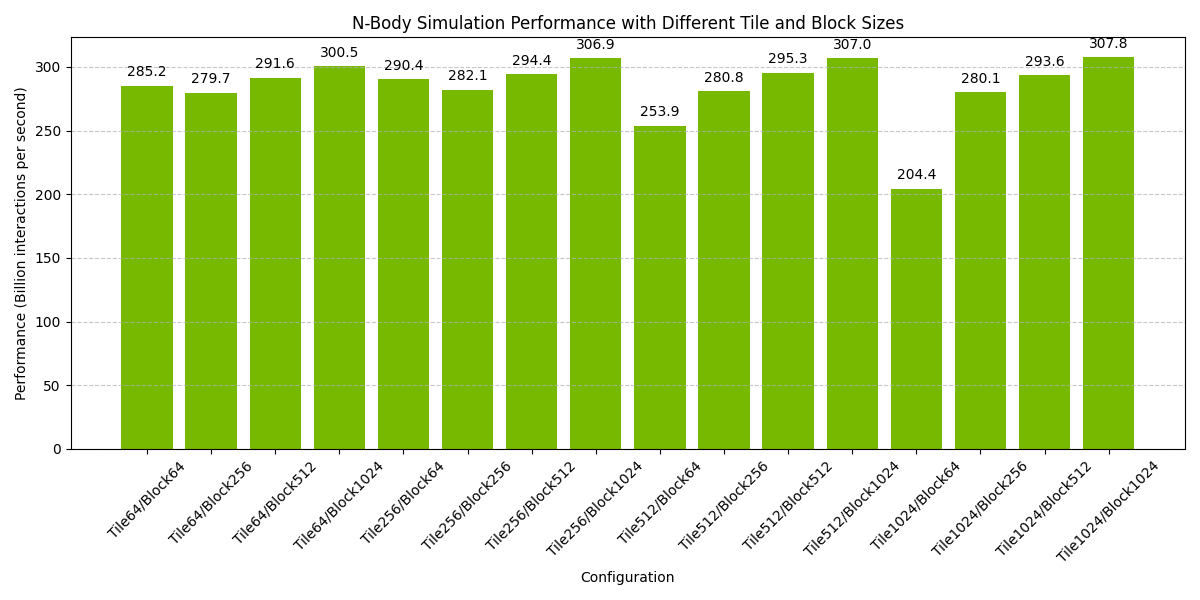

In [24]:
# Enable interactive matplotlib widgets for notebook
%matplotlib widget
from itertools import product
import matplotlib.pyplot as plt


# Define parameter ranges for performance testing
# Combinations to run for block_dim and tile_size
block_list = [64, 256, 512, 1024]
tile_list = [64, 256, 512, 1024]

# Generate all possible combinations of tile and block sizes
configs = list(product(tile_list, block_list))

# Run benchmarks for each configuration and collect results
results = []
for c in configs:
    perf_result = benchmark_warp(c)
    results.append(perf_result / 1e9)  # Convert the output PIPS to billions

# Create labels for x-axis showing tile and block size combinations
labels = [f"Tile{c[0]}/Block{c[1]}" for c in configs]

# Create the bar chart with performance results
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(results)), results, color="#76b900")
plt.xlabel("Configuration")
plt.ylabel("Performance (Billion interactions per second)")
plt.title("N-Body Simulation Performance with Different Tile and Block Sizes")
plt.xticks(range(len(labels)), labels, rotation=45)

# Add value labels on top of each bar for better readability
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 5,
        f"{results[i]:.1f}",
        ha="center",
        va="bottom",
        rotation=0,
    )

# Apply formatting and styling to the plot
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)

---
## Conclusion

In this notebook, we examined different attempts to simulate the Ising model in two dimensions.

The main goal of this exercise was to illuminate some considerations when writing algorithms that run **correctly** and **efficiently** on a GPU.

Starting from a sequential Python version, we encountered a fundamental challenge: while separating the lattice into "current" and "updated" grids eliminates race conditions, this approach inadvertently alters the underlying physics, producing an algorithm that no longer faithfully reproduces the statistical mechanics of the original sequential implementation.

Finally, we saw that a checkerboard algorithm allows us to recover the intended physics while addressing the data dependency issues that hindered the initial approaches.

---
## References

You can find the Warp GitHub repository and documentation below:
* "NVIDIA/warp: A Python framework for accelerated simulation, data generation and spatial computing.", GitHub, https://github.com/NVIDIA/warp.
* Warp Developers, "NVIDIA Warp Documentation," GitHub Pages, https://nvidia.github.io/warp.

Note: This tutorial was inspired by [Romero et al.'s](https://www.sciencedirect.com/science/article/abs/pii/S0010465520302228) work on GPU-accelerated 2-D Ising model simulations.